In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import os
from dataclasses import dataclass, field

from typing import Dict, List, Tuple, Optional, Callable, Any

import numpy as np
from PIL import Image

from pysolotools.consumers import Solo
from pysolotools.converters.solo2coco import SOLO2COCOConverter
from pysolotools.core.models import KeypointAnnotationDefinition, RGBCameraCapture
from pysolotools.core.models import BoundingBox2DAnnotation as BBox2DAnno, BoundingBox3DAnnotation as BBox3DAnno
from pysolotools.core.models import BoundingBox2DLabel, BoundingBox3DLabel
from pysolotools.core.models import Frame, Capture
from scipy.spatial.transform import Rotation as R

from torchvision.datasets import ImageFolder
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
# from torch.utils.data import ConcatDataset, DataLoader
from collections import OrderedDict
from torch.utils.data import DataLoader
from scipy.io import savemat, loadmat
import torch.nn.functional as F

import torch
from torch import nn, Tensor
from torchvision.ops import FeaturePyramidNetwork

import lightning.pytorch as pl

import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork, MLP, sigmoid_focal_loss, StochasticDepth

from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from scipy.linalg import dft
from itertools import combinations as CWOR
from itertools import combinations_with_replacement as CWR
import transformer
import reader
import scipy
import network
import ca
from torchvision.datasets import VisionDataset
# from my_trainer import LitCVMPCA, HungarianMatcher, SetCriterion

# %matplotlib ipympl

In [16]:
train_folder = 'D:/Unity/dataset/solo'
# train_loader = reader.UnityDataset.from_unity_to_loader(train_folder, batch_size=4)

In [17]:
root = train_folder

transform = Swin_V2_T_Weights.DEFAULT.transforms()
transform.cuda()
backbone = transformer.Swin(is_trainable=False)
backbone.cuda()
backbone.eval()
print()

In [57]:
def cart2sph(coor):  # coor: [M, K, 3]
    '''
        y -> z
        z -> y
    '''
    x, y, z = coor[:, :, 0], coor[:, :, 1], coor[:, :, 2]
    XsqPlusYsq = x**2 + z**2
    # if (XsqPlusYsq == 0).any(): print('XsqPlusYsq', XsqPlusYsq)
    # if (x == 0).any(): print('x', x)

    r = np.sqrt(XsqPlusYsq + y**2)                              # r
    elev = np.arccos(y/r)                                       # phi
    az = np.sign(z) * np.arccos(x/np.sqrt(XsqPlusYsq))  + (x==0)*np.pi   # theta
    return r, np.nan_to_num(az), np.nan_to_num(elev)

def path_gain(dist, freq):      # dist in meters, freq in GHz
    c = 3e8
    return 10**(-(32.4+17.3*np.log10(dist)+20*np.log10(freq))/10), \
           10**(-(32.4+20*np.log10(freq)+31.9*np.log10(dist))/10), \
           10**(-(31.84+21.50*np.log10(dist)+19*np.log10(freq))/10), \
           (c / (4*np.pi*dist*freq*1e9))**2

def UPA_array_response(theta, phi, N_h, N_v):
    M, K = np.shape(theta)
    a2 = (ULA_array_response_2(theta, phi, N_h)[..., None] * np.expand_dims(ULA_array_response_1(theta, phi, N_v), -2)).reshape(M, K, -1)
    return a2

def ULA_array_response_2(theta, phi, N):
    if len(theta.shape) == 2:
        a = 1/np.sqrt(N) * np.exp(
            -1j*np.pi*np.sin(theta)[..., None]*np.sin(phi)[..., None]*np.reshape(np.arange(N), [1, 1, N])
        )
        
    else:
        a = 1/np.sqrt(N) * np.exp(
            -1j*np.pi*np.sin(theta)*np.sin(phi)*np.arange(N)
        )
    # print(np.linalg.norm(a[0,0]))
    return a

def ULA_array_response_1(theta, phi, N):
    if len(theta.shape) == 2:
        a = 1/np.sqrt(N) * np.exp(-1j*np.pi*np.cos(phi)[..., None]*np.reshape(np.arange(N), [1, 1, N]))
        
    else:
        a = 1/np.sqrt(N) * np.exp(
            -1j*np.pi*np.cos(phi)*np.arange(N)
        )
        
    return a

# def ULA_array_response_2(theta, phi, N):
#     if len(theta.shape) == 2:
#         a = 1/np.sqrt(N) * np.exp(
#             -1j*np.pi*np.cos(theta)[..., None]*np.sin(phi)[..., None]*np.reshape(np.arange(N), [1, 1, N])
#         )
        
#     else:
#         a = 1/np.sqrt(N) * np.exp(
#           -1j*np.pi*np.cos(theta)*np.sin(phi)*np.arange(N)
#         )
#     # print(np.linalg.norm(a[0,0]))
#     return a

# def ULA_array_response_1(theta, phi, N):
#     if len(theta.shape) == 2:
#         a = 1/np.sqrt(N) * np.exp(-1j*np.pi*np.sin(phi)[..., None]*np.sin(theta)[..., None]*np.reshape(np.arange(N), [1, 1, N]))
        
#     else:
#         a = 1/np.sqrt(N) * np.exp(
#         -1j*np.pi*np.sin(phi)*np.sin(theta)*np.arange(N)
#         )
#     return a


def cell_association(required_rate, beam_gain, V_max, noise):
    M, K = beam_gain.shape
    options = []
    for i in range(V_max):
        for ids in CWOR(np.arange(K), i+1):
            temp = np.zeros(K) # _temp.copy()
            temp[list(ids)] = 1
            options.append(temp)

    max_rate = -1
    best_ca = None
    for ca in CWR(options, M):
        ca = np.array(ca)
        if (ca.sum(1) > V_max).any(): continue
        # snr = np.sum(beam_gain*ca, axis=0)/noise
        snr = np.abs(np.sum(beam_gain*ca, axis=0))**2/noise
        # print(snr)
        rates = np.log2(1 + snr)
        # if (R:=rates.sum()) > max_rate and (rates >= required_rate).all() and (rates > 0).all():
        if (R:=rates.sum()) > max_rate and (rates > 0).all():
            max_rate = R
            best_ca = ca
    return best_ca


# def AoD_to_beamgain(base_loc, user_loc, esti_AoD, esti_distance, power, LoS, cell_asso, N_h, N_v, freq, noise):
def AoD_to_beamgain(base_loc, user_loc, esti_AoD, power, LoS, N_h, N_v, freq):
    M, K = base_loc.shape[0], user_loc.shape[0]
    
    distance, theta, phi = cart2sph(np.reshape(user_loc, [1, K, 3]) - np.reshape(base_loc, [M, 1, 3]))
    true_gain = np.sqrt(path_gain(distance, freq/1e9)[-2]) * LoS
    # print(true_gain)
    true_array_response = UPA_array_response(theta, phi, N_h, N_v)

    esti_theta, esti_phi = esti_AoD
    esti_beamforming = np.sqrt(power) * UPA_array_response(esti_theta, esti_phi, N_h, N_v)
    beam_gain = np.zeros([M, K], dtype=np.complex64)
    
    for m in range(M):
        for k in range(K):
            beam_gain[m, k] = np.vdot(np.sqrt(N_h*N_v) * true_gain[m, k] * true_array_response[m, k], esti_beamforming[m, k])

    return esti_beamforming, beam_gain

# def NR_beamforming_to_beamgain(base_loc, user_loc, power, LoS, cell_asso, N_h, N_v, freq, noise, num_os):
def NR_beamforming_to_beamgain(base_loc, user_loc, power, LoS, N_h, N_v, freq, num_os):
    M, K = base_loc.shape[0], user_loc.shape[0]
    
    distance, theta, phi = cart2sph(np.reshape(user_loc, [1, K, 3]) - np.reshape(base_loc, [M, 1, 3]))
    true_gain = np.sqrt(path_gain(distance, freq/1e9)[-2]) * LoS
    true_array_response = UPA_array_response(theta, phi, N_h, N_v)

    beam_codebook_h = dft(N_h*num_os)[:, :N_h]/np.sqrt(N_h)
    beam_codebook_v = dft(N_v*num_os)[:, :N_v]/np.sqrt(N_v)
    beam_codebook_BS = np.zeros((num_os**2*N_h*N_v, N_h*N_v), dtype=np.complex64)

    for i in range(num_os*N_h):
        for j in range(num_os*N_v):
            beam = np.sqrt(power) * np.kron(beam_codebook_h[i],beam_codebook_v[j])
            beam_codebook_BS[i*num_os*N_v + j] = np.reshape(beam, -1)

    beam_gain = np.zeros([M, K], dtype=np.complex64)
    beamforming_vector = np.zeros([M, K, N_h*N_v], dtype = np.complex64)
    best_beam_index = np.zeros((M, K))
    
    for m in range(M):
        for k in range(K):
            beam_sweeping_gain = np.matmul(np.conjugate(np.sqrt(N_h*N_v) * true_gain[m, k] * true_array_response[m, k]) , np.transpose(beam_codebook_BS))
            abs_beam_sweeping_gain = np.abs(beam_sweeping_gain)
            
            max_index = np.argmax(abs_beam_sweeping_gain)
            best_beam_index[m,k] = max_index
            beamforming_vector[m, k] = beam_codebook_BS[max_index]
            beam_gain[m, k] = beam_sweeping_gain[max_index]

    return beamforming_vector, beam_gain, beam_sweeping_gain

def sumrate_evaluation(beam_gain, cell_asso, noise):
    sum_rate = np.sum(np.log2(1 + np.abs(np.sum(beam_gain*cell_asso, 0))**2/noise))
    # print(np.mean(np.log2(1 + np.abs(np.sum(beam_gain*cell_asso, 0))**2/noise)))

    return sum_rate

def bf2angle(vector, N_h, N_v):
    M, K, N = vector.shape
    vector = vector / np.linalg.norm(vector,axis=-1)[..., None] * np.sqrt(N_h*N_v)
    UPA = vector.reshape((M,K,N_h,N_v))
    ULA_1 = UPA[:,:,0]
    ULA_2 = UPA[:,:,:,0]
    cosphi = np.real(np.log(ULA_1[:,:,1])/(-1j*np.pi))
    sinthetasinphi = np.real(np.log(ULA_2[:,:,1])/(-1j*np.pi))
    # print('sinthetasinphi:',sinthetasinphi)

    phi = np.arccos(cosphi)
    sintheta = (np.sin(phi) == 0) * 0 + (np.sin(phi) != 0) * sinthetasinphi/(np.sin(phi)+0.000001)
    
    theta = (cosphi >= 0) * np.arcsin(np.clip(sintheta,-1,1)) + \
    (cosphi < 0) * (sintheta >= 0) * (np.pi - np.arcsin(np.clip(sintheta,-1,1))) + \
    (cosphi < 0) * (sintheta < 0) * (-np.pi - np.arcsin(np.clip(sintheta,-1,1)))

    return (theta, phi)



In [58]:
freq = 100e9
V_max = 2
N_h, N_v = 16, 4
power = 100
noise = 1
min_req, max_req = 1e-7, 1e-6

In [62]:


solo = Solo(data_path=root)
category_lookup = {v: k-1 for k, v in solo.categories().items()}

for frame_idx, frame in enumerate(solo.frames()):
    print(f'\rLoading: {100*(frame_idx+1)/len(solo.frames()):.2f}% | {root}/sequence.{frame.sequence}', end='')

    img_paths = {
        capture.id: f'{root}/sequence.{frame.sequence}/{capture.filename}'
        for capture in frame.captures
    }
    for camera_key, path in img_paths.items():
        img = Image.open(path).convert('RGB')
        img = transform(img)
        _path = f'{path[:path.rfind("/")]}/{camera_key}.mat'
        outputs = backbone(img[None, ...].cuda())
        output_dict = {str(i): output[0].cpu().numpy() for i, output in enumerate(outputs)}
        savemat(_path, output_dict)
    
    objects = {}
    sbs_positions = {}
    capture_lookup = {}
    for capture in frame.captures:
        if capture.id not in sbs_positions: sbs_positions[capture.id] = capture.position
        if capture.id not in capture_lookup: capture_lookup[capture.id] = len(capture_lookup)

        anno_3d = [anno for anno in capture.annotations if isinstance(anno, BBox3DAnno)][0]
        if len(anno_3d.values) == 0: continue
        
        r = R.from_quat(capture.rotation)
        for bbox in anno_3d.values:
            # add new UE
            if bbox.labelName == 'phone':
                if bbox.instanceId not in objects:
                    objects[bbox.instanceId] = reader.Object(
                        instanceId=bbox.instanceId,
                        category=np.zeros(len(category_lookup)),
                        position=np.array(r.apply(bbox.translation)+capture.position),
                        los=np.zeros(len(frame.captures)),
                        required_rate=np.array([-1]),
                        ca=np.zeros(len(frame.captures)),
                    )
                    objects[bbox.instanceId].category[category_lookup[bbox.labelName]] = 1
                    # if bbox.labelName == 'phone':
                    objects[bbox.instanceId].required_rate = np.random.rand(1)*(max_req-min_req) + min_req

                objects[bbox.instanceId].los[capture_lookup[capture.id]] = 1
    if len(objects) == 0: continue

    M, K = len(sbs_positions), len(objects)
    sbs_positions = np.array([sbs for sbs in sbs_positions.values()])
    ue_positions = np.array([ue.position for ue in objects.values()])
    los = np.array([ue.los for ue in objects.values()]).T

    distance, theta, phi = cart2sph(ue_positions.reshape([1, K, 3]) - sbs_positions.reshape([M, 1, 3]))
    perfect_aod = (theta, phi)
    _, beam_gain = AoD_to_beamgain(sbs_positions, ue_positions, perfect_aod, power, los, N_h, N_v, freq)
    ca = cell_association(np.array([obj.required_rate for obj in objects.values()]), beam_gain, V_max, noise)
    if ca is None:
        print('ca')
    nr_beam_gains, ca_nr = {}, {}
    for num_os in range(1, 5):
        _, nr_beam_gain, _ = NR_beamforming_to_beamgain(
            sbs_positions, ue_positions, 
            power, los, N_h, N_v, freq, num_os=num_os
        )
        ca = cell_association(
            np.array([obj.required_rate for obj in objects.values()]), nr_beam_gain, V_max, noise
        )
        nr_beam_gains[str(num_os)] = nr_beam_gain
        if ca is None:
            print(f'ca {str(num_os)}')
        ca_nr[str(num_os)] = ca

    if os.path.exists(f'{path[:path.rfind("/")]}/objects.mat'):
        os.remove(f'{path[:path.rfind("/")]}/objects.mat')
    # if os.path.exists(f'{path[:path.rfind("/")]}/sbs.mat'):
    #     os.remove(f'{path[:path.rfind("/")]}/sbs.mat')
    savemat(
        f'{path[:path.rfind("/")]}/objects.mat',
        {
            'instanceId': np.array([obj.instanceId for obj in objects.values()]),
            'category': np.array([obj.category for obj in objects.values()]),
            'position': np.array([obj.position for obj in objects.values()]),
            'los': los, #np.array([obj.los for obj in objects.values()]),
            'required_rate': np.array([obj.required_rate for obj in objects.values()]),
            'ca': np.array(ca),  # (M, K)
            'file_paths': img_paths,
            'sbs_position': sbs_positions,
            'beam_gain_1': nr_beam_gains['1'],
            'ca_nr_1': ca_nr['1'],
            'beam_gain_2': nr_beam_gains['2'],
            'ca_nr_2': ca_nr['2'],
            'beam_gain_3': nr_beam_gains['3'],
            'ca_nr_3': ca_nr['3'],
            'beam_gain_4': nr_beam_gains['4'],
            'ca_nr_4': ca_nr['4'],
        }
    )

    # break

Loading: 100.00% | D:/Unity/dataset/solo/sequence.199

In [63]:

class UnityMatDataset(VisionDataset):

    def __init__(self, num_os, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_os = str(num_os)

        self.samples = []
        solo = Solo(data_path=self.root)

        # category_lookup = {'background': 0}
        category_lookup = {v: k-1 for k, v in solo.categories().items()}
        
        capture_lookup = {}

        for frame_idx, frame in enumerate(solo.frames()):
            for capture in frame.captures:
                capture_lookup[capture.id] = len(capture_lookup)
            print(f'\rLoading: {100*frame_idx/len(solo.frames()):.2f}%', end='')
            obj_path = f'{self.root}/sequence.{frame.sequence}'
            # objects = loadmat(f'{obj_path}/objects.mat')
            if not os.path.isfile(f'{obj_path}/objects.mat'): continue

            # if frame_idx == 2: break 
            self.samples.append(obj_path)
        # else:
        category_lookup['background'] = len(category_lookup)
        print(f'\rDataset loaded succesfully.')

        self.category_lookup = category_lookup
        self.capture_lookup = capture_lookup
        self.captures = frame.captures

    def __len__(self) -> int: return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[Dict[str, Image.Image], reader.Object]:
        obj_path = self.samples[index]
        objects = loadmat(f'{obj_path}/objects.mat')
        beam_gain = torch.tensor(objects[f'beam_gain_{self.num_os}'], dtype=torch.complex64)
        ca = torch.tensor(objects[f'ca_nr_{self.num_os}'], dtype=torch.float)
        return beam_gain, ca

    @staticmethod
    def _collate_fn(data: List[Tuple[Dict[str, Image.Image], reader.Object]]):
        beam_gains, cas = zip(*data)
        # for bg, ca in zip(beam_gains, cas):
        #     print(bg.shape, ca.shape)

        max_H = max([bg.shape[0] for bg in beam_gains])
        max_W = max([bg.shape[1] for bg in beam_gains])
        beam_gains = torch.stack([
            F.pad(bg, (max_H-bg.shape[0], max_W-bg.shape[1]), value=0)
            for bg in beam_gains
        ])
        cas = torch.stack([
            F.pad(ca,  (max_H-ca.shape[0], max_W-ca.shape[1]), value=0)
            for ca in cas
        ])

        return beam_gains, cas

    @classmethod
    def from_unity(cls, root, num_os):
        return cls(
            root=root, num_os=num_os,
            transform=Swin_V2_T_Weights.DEFAULT.transforms(),
            # target_transform=Object.batchify
        )
    
    @classmethod
    def from_unity_to_loader(cls, root, num_os, batch_size=4, num_workers=0):
        return DataLoader(
            cls.from_unity(root=root, num_os=num_os),
            batch_size=batch_size, num_workers=num_workers, shuffle=True,
            collate_fn=cls._collate_fn, pin_memory=True
        )

In [64]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU(inplace=True),
            nn.GELU()
        )

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.down_1 = ConvBlock(2*in_channels, 16)
        # self.down_1 = ConvBlock(in_channels, 16, kernel_size=5, padding=2)
        self.down_2 = ConvBlock(16, 32)
        self.down_3 = ConvBlock(32, 64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        
        self.up_1 = ConvBlock(64, 32)
        self.up_2 = ConvBlock(32, 16)
        self.up_3 = ConvBlock(16, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        B, C, H, W = x.shape
        x = torch.cat([x.real, x.imag], dim=1)
        x = F.pad(x, (0, W%2, 0, H%2), mode='circular', value=0)

        x1 = self.down_1(x)
        x2 = self.down_2(x1)
        x3 = self.down_3(x2)

        x = self.pool(x3)
        x = self.up(x)

        y1 = self.up_1(x3)
        y2 = self.up_2(y1 + x2)
        y = self.up_3(y2 + x1)
        return y[:, :, :H, :W]
    
# output = net(
#     torch.rand(1, 1, 5, 10, dtype=torch.complex64)
# )


for num_os in range(1, 5):
    # print(f'num_os: {num_os}')    
    train_loader = UnityMatDataset.from_unity_to_loader(train_folder, num_os, batch_size=8)
    net = UNet(1, 1)

    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-2, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(100):
        running_loss = 0.
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            beam_gains, ca = batch

            pred_ca = net(beam_gains.unsqueeze(1))
            # loss = criterion(pred_ca.squeeze(1), ca)
            loss = sigmoid_focal_loss(
                pred_ca.squeeze(1), ca,
                alpha=-1, gamma=1, reduction='mean'
            )
            loss.backward()
            optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            print(f'\rEpoch: {epoch+1}/{100} {idx}/{len(train_loader)} | Loss: {running_loss/(idx+1):.4f}', end='')
        # print()
    torch.save(net.state_dict(), f'./unet_{num_os}.pth')
    print()
        # if i == 10: break

Dataset loaded succesfully.
Epoch: 100/100 24/25 | Loss: 0.1833
Dataset loaded succesfully.
Epoch: 100/100 24/25 | Loss: 0.1940
Dataset loaded succesfully.
Epoch: 100/100 24/25 | Loss: 0.1854
Dataset loaded succesfully.
Epoch: 100/100 24/25 | Loss: 0.1676


In [65]:

unets = {}
for i in range(1, 5):
    unet = UNet(1, 1)
    unet.load_state_dict(torch.load(f'./unet_{i}.pth'))
    unet.eval()
    unets[str(i)] = unet

In [13]:
fprs, tprs = [], []
with torch.no_grad():
    for num_os in range(1, 5):
        preds, labels = [], []
        train_loader = UnityMatDataset.from_unity_to_loader(train_folder, num_os, batch_size=8)
        net = UNet(1, 1)
        net.load_state_dict(torch.load(f'./unet_{num_os}.pth'))
        net.eval()
        for idx, batch in enumerate(train_loader):
            beam_gains, ca = batch
            pred_ca = net(beam_gains.unsqueeze(1))
            preds.extend(pred_ca.sigmoid().squeeze(1).flatten(0, 2).numpy())
            labels.extend(ca.flatten(0, 2).numpy())
            # print(beam_gains.shape, pred_ca.shape, ca.shape)

            # if idx == 2: break
            
        fpr, tpr, thresholds = roc_curve(np.array(labels).ravel(), np.array(preds).ravel(), pos_label=1)
        fprs.append((f'UNet-{num_os}', fpr))
        tprs.append((f'UNet-{num_os}', tpr))
        # RocCurveDisplay.from_predictions(
        #     # labels, predictions,
        #     np.array(labels).ravel(), np.array(preds).ravel(),
        #     pos_label=1,
        #     name=f'CV-CA {num_os}',
        #     color="darkorange",
        #     plot_chance_level=False,
        # )
        # plt.axis("square")
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.title("ROC curve of UE detection")
        # plt.legend()
        # plt.show()
        # break


Dataset loaded succesfully.
Dataset loaded succesfully.
Dataset loaded succesfully.
Dataset loaded succesfully.


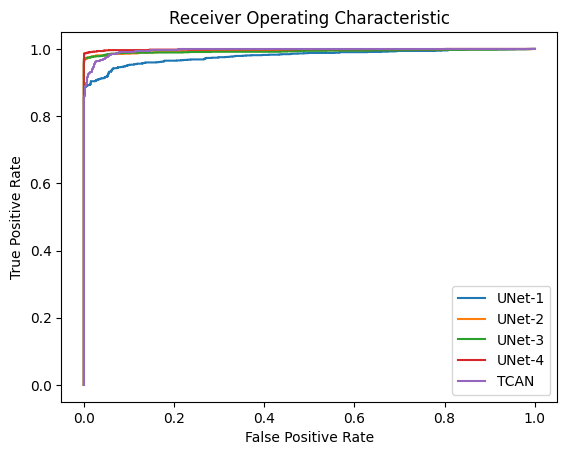

In [14]:
cvca_roc = loadmat('./cvca_ca_roc.mat')
cvca_labels, cvca_predictions = cvca_roc['label'][0], cvca_roc['pred'][0]
fpr, tpr, thresholds = roc_curve(cvca_labels, cvca_predictions, pos_label=1)
fprs.append((f'TCAN', fpr))
tprs.append((f'TCAN', tpr))


# plt.plot(fpr_1, tpr_1, label= "DETR")
for (name, fpr), (_, tpr) in zip(fprs, tprs):
    plt.plot(fpr, tpr, label=name)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:
beam_gains.shape, ca.shape

In [ ]:
RocCurveDisplay.from_predictions(
    # labels, predictions,
    np.array(labels).ravel(), np.array(preds).ravel(),
    pos_label=1,
    name='CV-CA',
    color="darkorange",
    plot_chance_level=False,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of UE detection")
plt.legend()
plt.show()

In [ ]:
pred_ca